# PROGETTO : ANALISI DEGLI ARGOMENTI TRATTATI SU TWITTER DAI PRINCIPALI POLITICI ITALIANI DURANTE IL PERIODO COVID-19

In [1]:
import inspect
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from pprint import pprint
from scipy.sparse import lil_matrix
import itertools
import random
from scipy import sparse as sp
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


C:\Users\Lorenzo\anaconda3\envs\msbd\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Caricamento e preparazione dei dati

In [2]:
# Lettura dei dati 
dati = pd.read_csv("tantitweet9.csv", encoding="utf-8", low_memory=False)
print("Dimensione del dataset: {} x {}".format(*dati.shape))

FileNotFoundError: [Errno 2] No such file or directory: 'tantitweet9.csv'

In [4]:
# Salvo il nome dei politici in una lista
nome_politici = dati["screen_name"].unique()
print(nome_politici)

['GiuseppeConteIT' 'nzingaretti' 'berlusconi' 'lauraboldrini' 'emmabonino'
 'luigidimaio' 'Roberto_Fico' 'carlaruocco1' 'Ettore_Rosato'
 'robersperanza' 'AnnaAscani' 'BeppeSala' 'BerniniAM' 'F_Boccia'
 'davidefaraone' 'paola_demicheli' 'ivanscalfarotto' 'matteosalvinimi'
 'matteorenzi' 'CarloCalenda' 'GiorgiaMeloni' 'zaiapresidente' 'marattin'
 'DSantanche' 'gasparripdl' 'AlbertoBagnai' 'TeresaBellanova'
 'lucianonobili' 'civati' 'giorgio_gori' 'pfmajorino' 'sbonaccini'
 'Rinaldi_euro' 'marcocappato' 'Antonio_Tajani' 'msgelmini'
 'mara_carfagna' 'Capezzone' 'AlessiaMorani' 'renatobrunetta']


In [5]:
# creo una lista contenente una lista per ogni politico dei suo tweet
tweet = []
for nome in (nome_politici):
        tweet.append(dati.loc[dati["screen_name"] == nome]["text"])

In [6]:
# filtro i tweet che sono piu lunghi di 200 caratteri
# per ogni tweet associo l'autore e lo salvo in una lista
tweet2 = []
autore = []
for i,t in enumerate(tweet):
    lista_temp = []
    for k in t:
        if len(k) > 200:
            lista_temp.append(k)
            autore.append(nome_politici[i])
    tweet2.append(lista_temp)

In [28]:
# numero tweet per politico
dim = []
for i,t in enumerate(tweet2):
    print(i,len(t), nome_politici[i]) 
    dim.append(len(t))

0 89 GiuseppeConteIT
1 254 nzingaretti
2 229 berlusconi
3 79 lauraboldrini
4 113 emmabonino
5 239 luigidimaio
6 79 Roberto_Fico
7 269 carlaruocco1
8 217 Ettore_Rosato
9 88 robersperanza
10 264 AnnaAscani
11 264 BeppeSala
12 170 BerniniAM
13 241 F_Boccia
14 216 davidefaraone
15 114 paola_demicheli
16 168 ivanscalfarotto
17 1214 matteosalvinimi
18 526 matteorenzi
19 1207 CarloCalenda
20 432 GiorgiaMeloni
21 440 zaiapresidente
22 419 marattin
23 315 DSantanche
24 321 gasparripdl
25 597 AlbertoBagnai
26 803 TeresaBellanova
27 551 lucianonobili
28 840 civati
29 157 giorgio_gori
30 399 pfmajorino
31 216 sbonaccini
32 514 Rinaldi_euro
33 321 marcocappato
34 311 Antonio_Tajani
35 338 msgelmini
36 214 mara_carfagna
37 818 Capezzone
38 300 AlessiaMorani
39 794 renatobrunetta


# Pre-processing

In [8]:
# Librerie utilizzate per il pre-processing
from bs4 import BeautifulSoup
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from string import punctuation
import tqdm
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [9]:
# Funzione che esegue le operazioni di pre-processing
def tweet_analyzer(tweet, tokenizer, stop_words):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = re.sub("http\S+", "", tweet)
    tweet = tweet.lower()
    tweet = tokenizer.tokenize(tweet)
    tweet = [token for token in tweet if token not in stop_words
        and not token.isdigit()]
    tweet = [token for token in tweet if len(token) > 1]
    return tweet

In [10]:
# liste di stopword scaricate da nltk
nltk.download("stopwords")
nltk.download("wordnet")
# lista di stopword contenti nomi e partiti dei politici e altre parole senza significato
piu_stopwords = ["oggi", "ora","solo","cosa","giuseppeconteit", "fatto", "quando", "poi", "dire","essere","mai","prima","molto","albertobagnai","borghi_claudio",
                "sempre","modo","punto","nulla","giorni","deve","così","può","cose","fa","anni","dobbiamo","the","alberto","bagnai","magari","ecco","gasparripdl",
                 "and","dare","due","tutte","insieme","berlusconi","l'italia","va","bisogna","meno","parte","ce","grande","oggi","fare","senza","quindi",
                "sempre", "grazie", "ancora", "momento", "ogni", "dopo", "già", "sempre", "salvini","ieri","altro","pd","lega","m5s","forza_italia",
                "borghi_claudio","italiaviva","matteosalvinimi","bonafede","teresabellanova","rinaldi_euro","giorgio_gori","civati","matteorenzi","sbonaccini",
                "boccia","pure","invece","ore","tanti","qui","fra","pdnetwork","nzingaretti","assembleapd","zappingradio1","lauraboldrini","sinistra","destra",
                "laura","boldirni","tutta","qualcuno","emmabonino","piueuropalive","emma","bonino","piu_europa","vedova","simona","luigidimaio","centrodestra",
                "roberto_fico","ettore_rosato","elenabonetti","ferra2113","robersperanza","viva","ep_president","europa_it","annaascani","link","serve",
                "azione_it","carlocalenda","fdi","fratelliditalia","giorgiameloni","zaiapresidente","marattin","fratelliditaiia","lucianonobili",
                "marcocappa_","silviaromano","pennacchiiiii","chiaralessi","rinaldi","antonio","paologentiloni","gentiloni","ass_coscioni","f_boccia",
                "marcocappato","filomena_gallo","antonio_tajani","de","el","en","msgelmini","enricoletta","de","et","les","st","mara_carfagna","bene",
                "far","pfmajorino","sbonaccini","bendellavedova","opencamera","laveritaweb","laveritaallesette","capezzone","alessiamorani","marco",
                 "renatobrunetta","giornatadellaterra","scorrettissima","politicamente","politicamente_scorrettissima","peoplepubit","gualtierieurope",
                "renzi","sa","troppo","pare","volete"]
stopwords2 = ['ad','al','allo','ai','agli','all','agl','alla','alle','con','col','coi','da','dal','dallo','dai','dagli','dalla','dalle','di','del','dello','dei','degli','della','delle','in','nel','nello','nei','negli','nell','negl','nella','nelle','su','sul','sullo','sui','sugli','sull','sugl','sulla','sulle','per','tra','contro','io','tu','lui','lei','noi','voi','loro','mio','mia','miei','mie','tuo','tua','tuoi','tue','suo','sua','suoi','sue','nostro','nostra','nostri','nostre','vostro','vostra','vostri','vostre','mi','ti','ci','vi','lo','la','li','le','gli','ne','il','un','uno','una','ma','ed','se','perché','anche','come','dove','che','chi','cui','non','più','quale','quanto','quanti','quanta','quante','quello','quelli','quella','quelle','questo','questi','questa','queste','si','tutto','tutti','ho','hai','ha','abbiamo','avete','hanno','abbia','abbiate','abbiano','avrò','avrai','avrà','avremo','avrete','avranno','avrei','avresti','avrebbe','avremmo','avreste','avrebbero','avevo','avevi','aveva','avevamo','avevate','avevano','ebbi','avesti','ebbe','avemmo','aveste','ebbero','avessi','avesse','avessimo','avessero','avendo','avuto','avuta','avuti','avute','sono','sei','è','siamo','siete','sia','siate','siano','sarò','sarai','sarà','saremo','sarete','saranno','sarei','saresti','sarebbe','saremmo','sareste','sarebbero','ero','eri','era','eravamo','eravate','erano','fui','fosti','fu','fummo','foste','furono','fossi','fosse','fossimo','fossero','essendo','faccio','fai','facciamo','fanno','faccia','facciate','facciano','farò','farai','farà','faremo','farete','faranno','farei','faresti','farebbe','faremmo','fareste','farebbero','facevo','facevi','faceva','facevamo','facevate','facevano','feci','facesti','fece','facemmo','faceste','fecero','facessi','facesse','facessimo','facessero','facendo','sto','stai','sta','stiamo','stanno','stia','stiano','starò','starai','starà','staremo','starete','staranno','starei','staresti','starebbe','staremmo','stareste','starebbero','stavo','stavi','stava','stavamo','stavate','stavano','stetti','stesti','stette','stemmo','steste','stettero','stessi','stesse','stessimo','stessero','stando']
LATIN_1_CHARS = [ "'",'e','-','-','-','-','-','-', "'","'",'"','"', '"','"','"','...',"'", "'", "'", "'", "'","'","+","-","=","(",")","’","‘","“","”", "»","«",""]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lorenzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lorenzo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('italian') + stopwords.words('english') + list(punctuation) + LATIN_1_CHARS + piu_stopwords + stopwords2

In [12]:
# creo la lista dei token dei tweet -- una sottolista per ogni politico
token = []
for t in tweet2:
    token.append([tweet_analyzer(k, tokenizer, stop_words) for k in t])

In [13]:
token2 = []
for i in range(0,len(token)):
    token2 = token2 + list(token[i])

# Analisi grafiche

In [14]:
from collections import Counter

In [ ]:
#token per il grafico per il singolo politico
token4 = []
for i in range(0,len(token)):
    token4.append(list(itertools.chain.from_iterable(token[i])))

In [ ]:
from wordcloud import WordCloud

In [ ]:
token_salvini=token4[17]
token_renzi=token4[18]
token_gasparri=token4[24]
token_boldrini=token4[3]
token_civati=token4[28]
token_calenda=token4[19]
token_renzi=token4[18]

In [ ]:
datogliere=["italia","italiani","governo","paese","stato","italiano","italiana","serve","altri","gasparri","gruppofisenato","boldrini","senato",
            "forzaitalia","senatostampa"]
token_salvini=[elem for elem in token_salvini if elem not in datogliere]
token_gasparri=[elem for elem in token_gasparri if elem not in datogliere]
token_civati=[elem for elem in token_civati if elem not in datogliere]
token_calenda=[elem for elem in token_calenda if elem not in datogliere]
token_renzi=[elem for elem in token_renzi if elem not in datogliere]
token_boldrini=[elem for elem in token_boldrini if elem not in datogliere]

In [ ]:
c_salvini=Counter(token_salvini)
c_gasparri=Counter(token_gasparri)
c_boldrini=Counter(token_boldrini)
c_civati=Counter(token_civati)
c_renzi=Counter(token_renzi)
c_calenda=Counter(token_calenda)


In [ ]:
## Per i colori delle parole nella wordcloud
def random_color_func_dx(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 80 / 255.0)
    s = int(100.0 * 255.0 / 255.0) #verde
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
def random_color_func_sx(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 2 / 255.0)
    s = int(100.0 * 255.0 / 255.0) #rosso
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
def random_color_func_centrodx(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 150 / 255.0)
    s = int(100.0 * 255 / 255.0) #blu
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h,s, l)

def random_color_func_rosa(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 0 / 255.0)
    s = int(100.0 * 255 / 255.0) #rosa
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(300,100, 50)

In [ ]:
MASK = plt.imread("figures/UntitledBlackCloud.jpg")
MAX_WORDS = 200
MAX_FONT_SIZE = 100
RELATIVE_SCALING = 0.1

plt.show()
plt.imshow(MASK)

wc_tutti = WordCloud(
    mask=MASK,
    max_words=MAX_WORDS, 
    background_color="white",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
).generate_from_frequencies(c_token)


wc_salvini= WordCloud(
    mask=MASK,
    max_words=MAX_WORDS, 
    background_color="white",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
    color_func=random_color_func_dx,
).generate_from_frequencies(c_salvini)

wc_gasparri= WordCloud(
    mask=MASK,
    max_words=MAX_WORDS, 
    background_color="white",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
    color_func=random_color_func_centrodx,
).generate_from_frequencies(c_gasparri)


wc_civati = WordCloud(
    mask=MASK,
    max_words=MAX_WORDS, 
    background_color="white",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
    color_func=random_color_func_sx,
).generate_from_frequencies(c_civati)

wc_boldrini = WordCloud(
    mask=MASK,
    max_words=MAX_WORDS, 
    background_color="white",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
    color_func=random_color_func_rosa,
).generate_from_frequencies(c_boldrini)



In [ ]:
###word cloud per tutti
plt.figure(figsize=(10, 20))
plt.imshow(wc_tutti, interpolation='bilinear')
plt.axis("off")

In [ ]:
## wordcloud salvini
plt.figure(figsize=(10, 20))
plt.imshow(wc_salvini,interpolation="bilinear")
plt.axis("off")

In [ ]:
#word cloud gasparri
plt.figure(figsize=(10, 20))
plt.imshow(wc_gasparri,interpolation="bilinear")
plt.axis("off")

In [ ]:
#wordcloud boldrini
plt.figure(figsize=(10, 20))
plt.imshow(wc_boldrini,interpolation="bilinear")
plt.axis("off")

In [ ]:
#wordcloud civati
plt.figure(figsize=(10, 20))
plt.imshow(wc_civati,interpolation="bilinear")
plt.axis("off")

# Modello

In [15]:
import gensim #conda install gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
import time
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [16]:
# creo dei token formati da due parole 
from gensim.models import Phrases

bigram = Phrases(token2, min_count=10)
for idx in range(len(token2)):
    for t in bigram[token2[idx]]:
        if '_' in t:
            token2[idx].append(t)

In [17]:
id2word = corpora.Dictionary(token2)
id2word.filter_extremes( no_below=10)
corpus = [id2word.doc2bow(text) for text in token2]

In [18]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5143
Number of documents: 15140


In [19]:
inizio = time.time()
num_topics = 20
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           passes=20,
                                           random_state = 142
                                           )
fine = time.time()
print("Durata: {:.2f}s".format(fine - inizio))

Durata: 169.74s


### Interpretazione dei topics

In [ ]:
# Distribuzione delle parole nei topic
for i in range(0,num_topics):
    print("Topic: ",i)
    print(lda_model.show_topic(i,6))

#### pyLDAvis
Funzione per l'intepretazione dei topic
https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [21]:
import pyLDAvis # pip install pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Visualizare i topic per l'interpretazione
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.169794 -0.040643       1        1  6.226181
11    -0.079074 -0.039598       2        1  6.064116
4     -0.207840 -0.016165       3        1  6.021466
6     -0.080914  0.097358       4        1  5.914571
14    -0.034609  0.041592       5        1  5.758757
16     0.033210 -0.162491       6        1  5.600019
17    -0.087853 -0.113277       7        1  5.343646
13     0.005303  0.095161       8        1  5.309009
2      0.129538 -0.075907       9        1  5.123012
3      0.014104 -0.058333      10        1  5.064320
8      0.142200 -0.046096      11        1  5.012191
15     0.273146  0.000227      12        1  4.784724
7     -0.041324 -0.089538      13        1  4.689970
9      0.176015  0.149500      14        1  4.607878
12    -0.010479 -0.177732      15        1  4.568859
19    -0.025566 -0.101693      16        1  4.446997
0      0.176097  0.040605      17        1  4.225995
1     -0.093212  0.245931      18        1  4.009896
5     -0.030086  0.197755      19        1  3.754351
18    -0.088862  0.053343      20        1  3.474043, topic_info=           Term         Freq        Total Category  logprob  loglift
151         mes  1034.000000  1034.000000  Default  30.0000  30.0000
2686   covid_19   918.000000   918.000000  Default  29.0000  29.0000
187     imprese   834.000000   834.000000  Default  28.0000  28.0000
534          ue   750.000000   750.000000  Default  27.0000  27.0000
2     emergenza  1386.000000  1386.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1045     capire    71.576767   158.173477  Topic20  -4.6924   2.5669
742     fiscale    61.902794   158.765549  Topic20  -4.8376   2.4180
59       lavoro    68.771759   847.811646  Topic20  -4.7324   0.8480
145       piano    54.096088   343.031677  Topic20  -4.9724   1.5128
1391     numero    52.795856   129.442108  Topic20  -4.9968   2.4631

[1110 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
38        7  0.964946        1maggio
115      10  0.986573       25aprile
3977     12  0.980528  _carabinieri_
2090      7  0.969173     abbastanza
2770      4  0.979397        accordi
...     ...       ...            ...
3542      8  0.221699           zero
3542     13  0.772372           zero
2717     14  0.989879     zingaretti
1036      1  0.985363           zona
3863      1  0.971487     zona_rossa

[2013 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 5, 7, 15, 17, 18, 14, 3, 4, 9, 16, 8, 10, 13, 20, 1, 2, 6, 19])

In [23]:
# Assegno ad ogni topic un titolo
topic_label = {'0':'terapia intensiva','1':'covid19 - lombardia','2':'palazzo chigi','3':'paese e solidarietà','4':'aiuto alle imprese e alle famiglie',
               '5':'volontari / finanza','6':'emergenza covid19','7':'economia (pil, miliardi, euro, ...)','8':'non definito','9':'ricorrenze',
               '10':'crisi del lavoro','11':'governo','12':'politica','13':'contagi e tamponi','14':'personale sanitario','15':'conferenza stampa',
               '16':'mes e europa','17':'lavoro - cassa integrazione','18':'spesa-crescita / scuola','19':'emergenza (sanitaria, economica)'}

### Frequenze dei topic

In [24]:
# creo un dataframe con: id_tweet, autore, topic dominante, 
topics_df = pd.DataFrame()
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
         if (j == 0):
            topics_df = topics_df.append(pd.Series([autore[i], topic_label[str(topic_num)]]), ignore_index=True)        
         else:
             break
topics_df.columns = ['Autore', 'Dominant_Topic']

In [31]:
c_topic_politico = []
for i,nome in enumerate(nome_politici):
    c_topic_politico.append(Counter(topics_df.loc[topics_df["Autore"] == nome]["Dominant_Topic"]))

In [32]:
c_topic = Counter(topics_df["Dominant_Topic"])

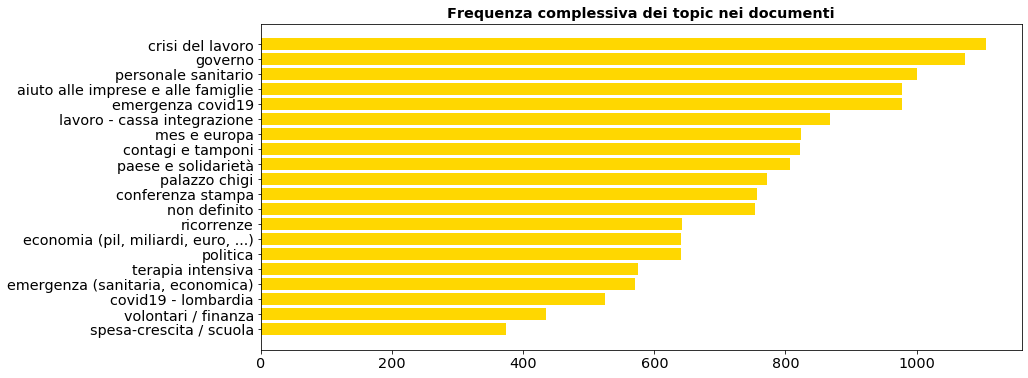

In [46]:
# grafico frequenza complessiva dei topic nei documenti
N = num_topics

plt.figure(figsize=(30, 6))

plt.subplot(121)
plt.title("Frequenza complessiva dei topic nei documenti", fontsize='x-large', fontweight=1000)
plt.barh(*zip(*c_topic.most_common(N)), color="gold")
plt.yticks(fontsize = "x-large")
plt.xticks(fontsize = "x-large")
plt.gca().invert_yaxis()
plt.show()

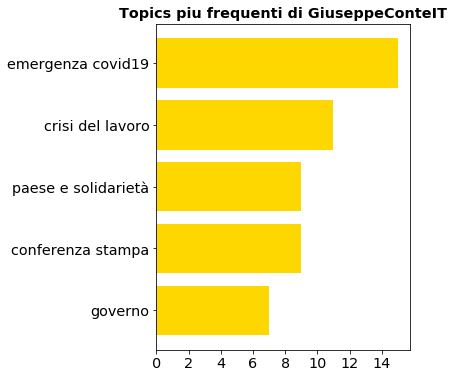

In [48]:
# grafico frequenza dei topic per singolo politico
N = num_topics
id_politico = 0
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.title("Topics piu frequenti di {}".format(nome_politici[id_politico]),fontsize='x-large', fontweight=1000)
plt.barh(*zip(*c_topic_politico[id_politico].most_common(5)), color="gold")
plt.yticks(fontsize = "x-large")
plt.xticks(fontsize = "x-large")
plt.gca().invert_yaxis()

plt.show()

In [70]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=142,
                                           #chunksize=100,
                                           passes=20,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=token2, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 20
max_topics = 60
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = [ '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=20)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            #for a in alpha:
                # iterare through beta values
                #for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a='auto', b='auto')
                    # Save the model results
                    #model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    #model_results['Alpha'].append(a)
                    #model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()











  0%|                                                                                           | 0/20 [00:00<?, ?it/s]









  5%|████                                                                              | 1/20 [01:54<36:12, 114.35s/it]









 10%|████████▏                                                                         | 2/20 [03:44<33:58, 113.22s/it]









 15%|████████████▎                                                                     | 3/20 [05:35<31:52, 112.52s/it]









 20%|████████████████▍                                                                 | 4/20 [07:24<29:43, 111.44s/it]









 25%|████████████████████▌                                                             | 5/20 [09:14<27:42, 110.85s/it]









 30%|████████████████████████▌                                                         | 6/20 [11:02<25:41, 110.14s/it]









 35%|████████████████████████████▋                                                     

ValueError: arrays must all be same length